<a href="https://colab.research.google.com/github/timmmariya/Empirical-Law-Studies/blob/main/1%22_%D0%9E%D1%87%D0%B8%D1%81%D1%82%D0%BA%D0%B0_%D0%A1%D1%80%D0%BE%D0%BA%D0%BE%D0%B2_%D1%80%D0%B0%D1%81%D1%81%D0%BC%D0%BE%D1%80%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np          # библиотека для матриц и математики
import pandas as pd         # библиотека для работы с табличками
from scipy import stats     # модуль для работы со статистикой
from matplotlib import colors

#библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot') # стиль графиков
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/twenty_years_base/2010_2014.csv"
df = pd.read_csv(path, sep=',')

In [ ]:
(df['FinishDate'] > '2022-**-**').sum()

61

In [ ]:
df = df[df['FinishDate'] < '2022-**-**']

In [ ]:
df['StartDate'].sort_values().head()

4872939    1900-01-01
5849866    1993-01-13
2835991    1993-01-25
4322386    1993-02-18
6976478    1993-05-19
Name: StartDate, dtype: object

In [ ]:
df = df[df['StartDate'] > '1990-**-**']

In [ ]:
# каст из строк к датам - подсказка для python, чтобы сократить
# количество приведений типов при дальнейших вычислениях
df['StartDate'] = pd.to_datetime(df['StartDate'])
df['FinishDate'] = pd.to_datetime(df['FinishDate'], errors='coerce')
df['ConsidTime'] = df['FinishDate'] - df['StartDate']

df['ConsidTime'] = pd.to_timedelta(df['ConsidTime'], unit='D')

#### Теперь обрабатываемый датасет хранится в следующем виде:

In [ ]:
df.head()

,CaseID,StartDate,FinishDate,CourtID,CategoryID,ClaimSum,RecoverySum,ConsidTime
0,CCC5C8FC-18F8-4263-89AB-00000008BB6D,2010-05-27,2010-08-12,17,77,125302.48,NaN,77 days
1,5B63D497-B664-47C8-BA91-0000008D3DA6,2013-05-28,2013-11-15,40,9,822478.73,8822478.73,171 days
2,9B82102F-19F2-4D9D-847A-0000028A0E8D,2014-08-04,2014-10-22,35,159,0.00,NaN,79 days
3,286CE894-23B9-48A5-A832-0000029A1005,2010-06-29,2011-03-24,55,22,14868.02,8134.01,268 days
4,225F2DBD-DEC1-4CE5-A220-00000EF99B7C,2009-12-01,2010-06-22,56,179,93.40,NaN,203 days


## **Базовые проверки на корректность**

#### Содержит ли база **строки-дубликаты**? 

Если да, то следует исключить повторения - каждое дело должно учитываться ровно 1 раз

In [ ]:
len1 = df.shape[0]
print('Записей до чистки дубликатов:', len1)
df = df.drop_duplicates()
len2 = df.shape[0]
print('После чистки:', len2)

if (len1 > len2) :
  print('\nОбнаружены дубликаты записей! Исключено ', (len1 - len2), ' дел')
else :
  print('\nДанные чистые! Дубликатов нет')

Записей до чистки дубликатов: 7189837
После чистки: 7189837

Данные чистые! Дубликатов нет



#### **Про сроки расмотрения**
При ручном вводе информации о деле в базу КАД случаются ошибки в наборе дат. Отследить и удалить из рассмотрения возможно только записи, содержащие противоречивую информацию - **отрицательное знаение в столбце "Продолжительность"** (дата конца меньше даты начала).

In [ ]:
df.groupby('CategoryID')['ConsidTime'].agg(['min', 'max'])

,min,max
CategoryID,,
1,-477 days,6861 days
3,-630 days,7040 days
4,-918 days,8718 days
9,-655 days,8235 days
11,-630 days,8266 days
13,-139 days,4310 days
14,-894 days,7202 days
18,-648 days,6550 days
19,-203 days,4638 days


Действительно, наш датасет содержит такие записи, причем они присутствуют практически во всех видах споров. Сохраним информацию о них в dataframe **error_dates** и подсчитаем их количество в каждом из судов (~регионов). Выведем для наглядности топ судов с ошибками в датах.

In [ ]:
error_dates = df[df['StartDate'] > df['FinishDate']]
error_regions = error_dates.groupby('CourtID')['CaseID'].agg(['count']).sort_values(by=['count'], ascending=False)
error_regions[:10]

,count
CourtID,
40,1894
43,737
65,592
35,416
50,384
78,369
45,368
14,345
33,283


Теперь уберем их из рассмотрения, очистив данные.

In [ ]:
df = df[df['StartDate'] <= df['FinishDate']]
len3 = df.shape[0]
if (len2 > len3) :
  print('Ошибки ввода дат в ', (len2 - len3), ' записях')
  print('\nИтого,', (len2 - len3), ' строк удалены из базы, осталось:', df.shape[0])
else :
  print('Данные чистые! Во всех делах дата конца больше или совпадает с датой начала')

Ошибки ввода дат в  10911  записях

Итого, 10911  строк удалены из базы, осталось: 7178926


Проверим, что функции отработали корректно и больше отрицательных сроков нет:

In [ ]:
df.groupby('CategoryID')['ConsidTime'].agg(['min', 'max'])

,min,max
CategoryID,,
1,0 days,6861 days
3,0 days,7040 days
4,0 days,8718 days
9,0 days,8235 days
11,0 days,8266 days
13,0 days,4310 days
14,0 days,7202 days
18,0 days,6550 days
19,0 days,4638 days


**!** Может быть, имеет место и обратное? Ошибки в сроках, связанные с выбросами "в плюс", **переполнения по длительности**
  > Присутствуют ли в базе такие записи о делах, продолжительность рассмотрения которых не является типичной/допустимой для спора этой категории или подобное? Если да, то действительно ли имел место такой прецедент или в данных есть ошибка?

Как видно из группировки по Видам спора ячейкой выше, наибольшая продолжительность рассмотрения одного дела составляет:

In [ ]:
max_len = df['ConsidTime'].max().days
print(max_len, "дня")

8718 дня


Как распределены значения величины "Продолжительность ('ConsidTime')"? Длинные ли хвосты? Построим **гистограмму**

In [ ]:
df['ConsidTime'] = df['ConsidTime'].dt.days

**Микровывод:** Распределение со скачками, некоторые пока не выясненные обстоятельства ("подгон отчетности" ?) искажают выборку

In [ ]:
df.groupby('ConsidTime')['ConsidTime'].agg(['count']).sort_values(by='count', ascending=False)[:10]

,count
ConsidTime,
91,63114
77,61697
84,60384
98,55452
105,53683
62,52721
63,51795
112,51725
61,51125


In [ ]:
df_dates = df[['StartDate', 'FinishDate', 'ConsidTime', 'CourtID', 'CategoryID']]

In [ ]:
df_dates.to_csv('/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/twenty_years_base/2010_2014_cleaned_dates.csv', index=False)

In [ ]:
df_sums = df[['CaseID', 'ClaimSum', 'RecoverySum', 'CourtID', 'CategoryID']]
df_sums.to_csv('/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/twenty_years_base/2010_2014_cleaned_sums.csv', index=False)

## **Общие наблюдения, простейшие визуализации**

### Функция настройки визуализации **```group_minor_values_and_pie(df, column, type, param)```**

Предназначена для наглядного изображения круговых диаграмм. 

Отбирает в столбце таблицы **df** с названием **column**, (передаются в качестве первых двух параметров), содержащем качественный признак, несколько самых часто встречающихся значений. Объединяет строки, не попавшие этот список, в одну группу - "Другие".

В зависимости от значения параментра **type** порог включения в список отображаемых на диаграмме вычисляется одним из двух способов:

1) если **type == 1**, то в **param** передается точное количество самых часто встречающих значений, которое нужно отобразить без обобщения. Реализована проверка на корректность входа (предупреждение о выходе за границы массива);

2) иначе вычисляется квантиль уровня **param** (ввести число от 0 до 1 - вероятность)

**В планах:** Сделать визуализации более красивыми, настроить цвета и легенду отдельным списом в стороне (например, используя советы отсюда https://blog.algorexhealth.com/2018/03/almost-10-pie-charts-in-10-python-libraries/)

In [ ]:
def group_minor_values_and_pie(df, column, type, param):
    d = df[column].value_counts()/df.shape[0]
    val = "Пороговое значение"
    if (type == 1) :
      if (param > len(d) or param <= 0) :
          print("Значение параметра больше, чем количество различных значений в таблице!")
          return
      pval = d[:param].min()
    else :
      pval = d.quantile(param)
    dtfr = pd.DataFrame(d.values, index=d.index)
    dtfr = dtfr[dtfr[0] >= pval]
    other_num = 1 - dtfr[0].sum()
    dtfr.loc['Другие'] = other_num

    cmap = plt.get_cmap('Spectral')
    colors = [cmap(i) for i in np.linspace(0, 1, 8)]

    fig, ax = plt.subplots()
    ax.pie(dtfr.values, labels=dtfr.index, autopct='%1.1f%%', pctdistance=1.15, wedgeprops={'lw':1,'edgecolor':"k"}, colors=colors, labeldistance=1.3)
    ax.axis("equal");

    #plt.title('Диаграмма распределения дел по Видам Споров', fontsize=16)

    plt.show();   

### **О судах, фигурирующих в базе**

1.  Сколько Судов предоставили информацию о своих делах? 
2.  Дел из каких судов больше всего? Меньше всего?
    > Взять справку у юристов: соответствует ли полученная пропорция статистике по РФ или данные по некоторым судам неполные? Следует ли посчитать их недостаточными для содержательного аналитического заключения и исключить из рассмотрения?

In [ ]:
courts = len(df['CourtID'].unique())
print('1)', 'Различных судов в базе:', courts)

print('2)')
courts_num = df['CourtID'].value_counts()
courts_perc = courts_num 

print('Суды, дела которых встречаются чаще всего (часть от общего числа дел в %):\n')
top_cperc = pd.DataFrame(df['CourtID'].value_counts() /df.shape[0] * 100)[:5]
print(top_cperc)

print('\n\nКол-во судов, рассмотревших менее 1000 дел в базе:', (df['CourtID'].value_counts() < 1000).sum())
bottom_cperc = pd.DataFrame(df['CourtID'].value_counts())[-14:]
print(bottom_cperc)

**!** Отметим, что среди всех судов **менее 100 дел предоставили все суды ФАС и ВАС РФ только они**, а менее 1000 еще на 1 суд больше (21 ААС). Предлагается выделить эту группу судов как кандидата на выброс и запросить экспертную оценку у юристов лаборатории.

In [ ]:
group_minor_values_and_pie(df, 'CourtID', 1, 10)

### **О Категориях споров**

* Какая доля дел приходится на разные категории? Каких споров больше всего?

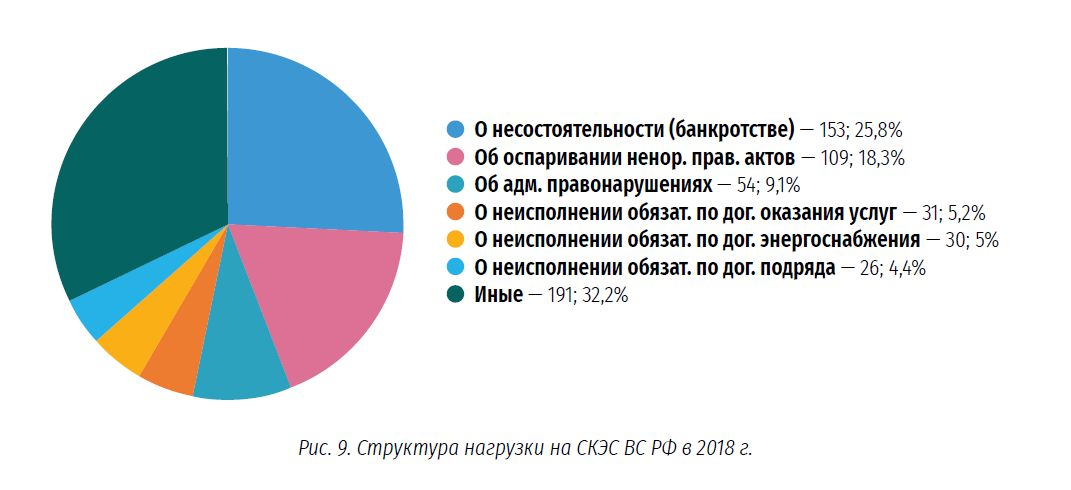

In [ ]:
group_minor_values_and_pie(df, 'CategoryID', 1, 10)

In [ ]:
df['CategoryID'].value_counts()

In [ ]:
#df.to_csv('/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/ArbitrageCleaned.zip', index=False, compression=dict(method='zip', archive_name='APwithEndDates.csv'))

## **Заметки про функции распределения**

In [ ]:
df_categ1 = df[df['Категория Спора'] == 'О неисполнении или ненадлежащем исполнении обязательств по договорам поставки']

df_categ1.head()

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

sample = df_categ1['Продолжительность'].to_numpy(copy=True)
sample.sort()

In [ ]:
plt.hist(df_categ1['Продолжительность'].apply(lambda x: np.log(x + 1)), bins=100);

In [ ]:
ecdf = ECDF(sample)   # строим эмпирическую функцию по выборке

plt.step(ecdf.x, ecdf.y)
plt.ylabel('$F(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20);

In [ ]:
plt.figure(figsize=(10,8))

s1 = df_categ1[df_categ1['Начало'] < '2015-02-01']['Продолжительность'].to_numpy(copy=True)
ecdf1 = ECDF(s1)
plt.step(ecdf1.x, ecdf1.y, label='Январь')

s2 = df_categ1[(df_categ1['Начало'] < '2015-03-01') & (df_categ1['Начало'] >= '2015-02-01')]['Продолжительность'].to_numpy(copy=True)
ecdf2 = ECDF(s2)
plt.step(ecdf2.x, ecdf2.y, label='Февраль')

s3 = df_categ1[(df_categ1['Начало'] < '2015-04-01') & (df_categ1['Начало'] >= '2015-03-01')]['Продолжительность'].to_numpy(copy=True)
ecdf3 = ECDF(s3)
plt.step(ecdf3.x, ecdf3.y, label='Март')

plt.legend(loc='best')
plt.ylabel('$F(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20);

